In [1]:
# Download the test dataset (all four images)
# this could take a few minutes ... about 12 GB of data
from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639([1,2,3,4])

In [2]:
# You can set your own libraries search path by adding M2AIA_PATH to your system environment variables
#  - For installed versions of M2aia point to the /path/to/m2aia/installation/bin directory
#  - For compiled versions of M2aia point to the /path/to/m2aia/build/MITK-build/lib directory

import os
# os.environ["M2AIA_PATH"] = "/home/jtfc/HS/M2aia/m2aia-dev/m2aia-release/MITK-build/lib/"

In [3]:
from pathlib import Path

# Model params
latent_dim = 5
interim_dim = 256
batch_size = 512


# Training params
epochs = 25

# lists for models and image handles
encoders = []
models = []
images = []
# prepare the 'models' dir
models_root = Path("models")
models_root.mkdir(exist_ok=True)

# load seaborn
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(19,6)})


In [4]:
import m2aia as m2
from msiPL.Computational_Model import VAE_BN
import tensorflow as tf


from Example_IV_Helpers import *
from msiPL.LearnPeaks import LearnPeaks
from keras.models import Model
import numpy as np
from Example_IV_Helpers import BatchSequence
import time

# Load Data
# You could replace file_names with your own local data
# e.g.: file_names = ["path/to/file1.imzML", "path/to/file12.imzML", ...]

learned_peaks = []
mean_orig_spectra = []
recon_spectrum_mean_list = []


z_image_list = []
x_dims = []
y_dims = []




for f in file_names:
    
    # load the file and add it to the image handle list
    I:m2.ImzMLReader = m2.ImzMLReader(f)
    images.append(I)

    # get the input dimension of spectra
    mz_selection = np.array(list(range(0,I.GetXAxisDepth(),2)))
    with tf.device('/gpu:0'):
        # Create a model for each image and add it to the models list
        vae = VAE_BN(I.GetXAxisDepth(), interim_dim, latent_dim)
        vae_model, encoder = vae.get_architecture()
        decoder = vae.decoder
        models.append(vae_model)
        encoders.append(encoder)

        # get the file's name
        f_name = Path(f).name

        load_models = True
        dataset = m2.Dataset.SpectrumDataset([I])
        gen = BatchSequence(dataset, batch_size=batch_size, shuffle=True)


        # check if model exists
        if os.path.exists(f'models/{interim_dim}_{f_name}.h5') and load_models:
            # ============= Load Model =================
            vae_model.load_weights(f'models/{interim_dim}_{f_name}.h5')
        else:
            # ============= Start Training =================

            # create a Batch generator using tensorflow'w tf.keras.utils.Sequence
            history = vae_model.fit(gen, epochs=epochs)
            # ============= Save Model =================
            vae_model.save_weights(f'models/{interim_dim}_{f_name}.h5')
        

        msiPl_beta = 1.3 #[1,2.5]
        var = image_variance(I)
        
        # ============= Analyze the model's encoder to find peaks ==============
        _, _, _, Real_PeakIdx = LearnPeaks(I.GetXAxis(), encoder.get_weights(), np.sqrt(var), latent_dim, msiPl_beta, I.GetMeanSpectrum())
        learned_peaks.append(Real_PeakIdx)

        # bring back to order
        dataset.elements.sort(key=lambda x: x[1])
        print(dataset[0][0].shape)


        x_dim, y_dim, z_dim = I.GetShape()
        x_dims.append(x_dim)
        y_dims.append(y_dim)

        z_image = np.zeros((latent_dim, y_dim, x_dim))
        recon_spectrum_sum = np.zeros((batch_size,I.GetXAxisDepth()))
        
        for id, (X, label) in enumerate(gen):
            _, _, z = encoder.predict(X)
            recon_spectrum_sum += decoder.predict(z)
            for k in range(batch_size):

                x,y,_ = I.GetSpectrumPosition(k+batch_size*id)

                z_image[:, y, x] = z[k,:]
                print(id/len(gen), end="\r")
                        
        recon_spectrum_mean_list.append(np.sum(recon_spectrum_sum, axis=0) / I.GetNumberOfSpectra())
        z_image_list.append(z_image)
            

[Sat Nov 18 11:46:10 2023 
20.623] [imzML]: data/150429_ew_section1_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 206x107x1
	[num spectra]: 16418
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
(1, 29693)
[63.191] [imzML]: data/150429_ew_section2_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 220x171x1
	[num spectra]: 26744
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
(1, 29693)
[115.848] [imzML]: data/150505_ew_section3_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 224x169x1
	[num spectra]: 28278
	[spec. type]: ContinuousProfile
	[mass range]: 99.792458 to 1285.640137 with #29693 measurements
(1, 29693)
[168.996] [imzML]: data/150417_ew_section4_pos.imzML
	[pixel size (mm)]: 0.025000x0.025000x0.010000
	[image dimension]: 197x192x1
	[num spectra]: 28156
	[spec. type]: ContinuousProfile
	[mass r

(-3.5, 1.0)

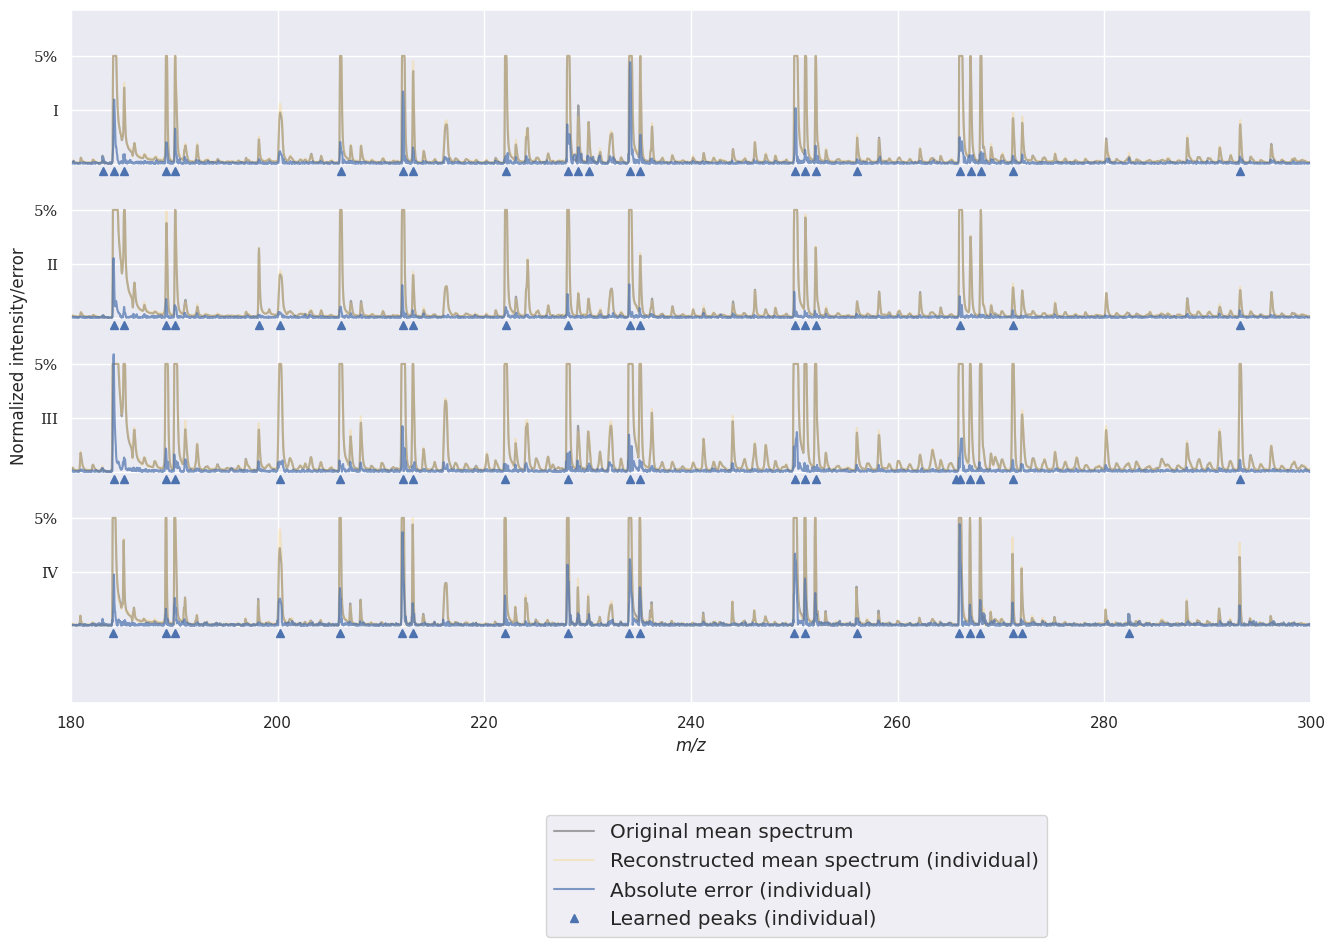

In [6]:
import matplotlib.pyplot as plt

xs = I.GetXAxis()
colors = ['r{}','g{}','b{}','y{}']
section_names = ['I', 'II', 'III', 'IV']
labels = []
y_tick = []
y_lines = []
y_tick_label = []
scale_factor = 0.7
fraction_of_max = 0.05
stretch_factor = 1
plt.figure(figsize=(16,9))
I : m2.ImzMLReader

for i, I in enumerate(images):
    y_tick.append(-i*stretch_factor)
    y_lines.append(-i*stretch_factor-0.15)
    y_tick.append(((-i*stretch_factor)+(-i*stretch_factor+scale_factor))*0.5)
    y_tick.append(-i*stretch_factor+scale_factor)
    y_tick_label.append('')
    y_tick_label.append(f'{section_names[i]}')
    y_tick_label.append(f'{int(fraction_of_max*100)}%')
    err1 = np.abs(I.GetMeanSpectrum()-recon_spectrum_mean_list[i])
    ys_err = err1/(np.max(I.GetMeanSpectrum())*fraction_of_max)
    plt.plot(xs, np.clip(I.GetMeanSpectrum()/(np.max(I.GetMeanSpectrum())*fraction_of_max),0,1)*0.7 - (i*stretch_factor),  color='grey', alpha=0.7)
    plt.plot(xs, np.clip(recon_spectrum_mean_list[i]/(np.max(I.GetMeanSpectrum())*fraction_of_max),0,1)*0.7 - (i*stretch_factor), color='#facd60', alpha=0.3)
    plt.plot(xs, err1/(np.max(I.GetMeanSpectrum())*fraction_of_max) - (i*stretch_factor), color='b', alpha=0.7)
    plt.plot(xs[learned_peaks[i]], [-(i*stretch_factor)-0.05 for _ in learned_peaks[i]], '^', color='b')

labels.append(f'Original mean spectrum')
labels.append(f'Reconstructed mean spectrum (individual)')
labels.append(f'Absolute error (individual)')
labels.append(f'Learned peaks (individual)')

plt.legend(labels=labels, fontsize='large', bbox_to_anchor=(0.375,-0.25), loc="center left")
plt.xlabel('m/z', fontdict={'style':'italic'})
plt.ylabel('Normalized intensity/error')
plt.yticks(y_tick, y_tick_label, fontdict={'family':'serif'})
plt.xlim([180, 300])
plt.ylim([-3.5, 1])
# plt.ylim([0, 50])


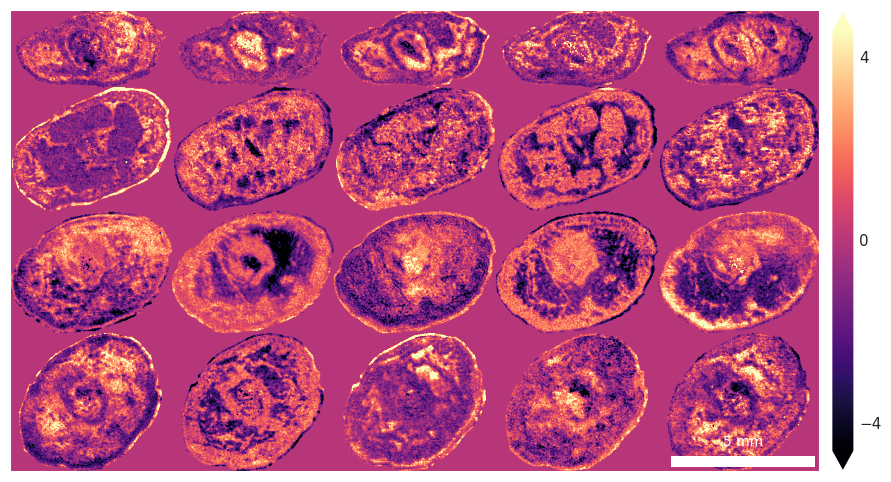

In [7]:
import seaborn_image as seaim
height = np.sum(y_dims)
max_im_width = np.max(x_dims)
width = max_im_width * latent_dim

im_final = np.zeros((height, width), np.float32)


y_pos = 0
for i, ims_temp in enumerate(z_image_list):
    d,h,w = ims_temp.shape
    min = np.min(ims_temp)
    max = np.max(ims_temp)
    x_pos = 0
    for k in range(latent_dim):
        
        rescaled = np.copy(ims_temp[k])
        mask = rescaled!=0
        w_delta_2 = (max_im_width-w)/2
        im_final[y_pos:y_pos + h , x_pos+int(w_delta_2):x_pos+int(w_delta_2)+w] = rescaled
        x_pos = x_pos + max_im_width
    y_pos = y_pos + h

seaim.imshow(im_final, cmap="magma", dx=25, units="um", perc=(1,99), robust=True,interpolation='bilinear')
plt.savefig(dpi=350, fname="results/example_iv_a.png")
